In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from ot import emd2  # Wasserstein distance computation

%matplotlib widget

# check available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset
Gaussian Mixture Model

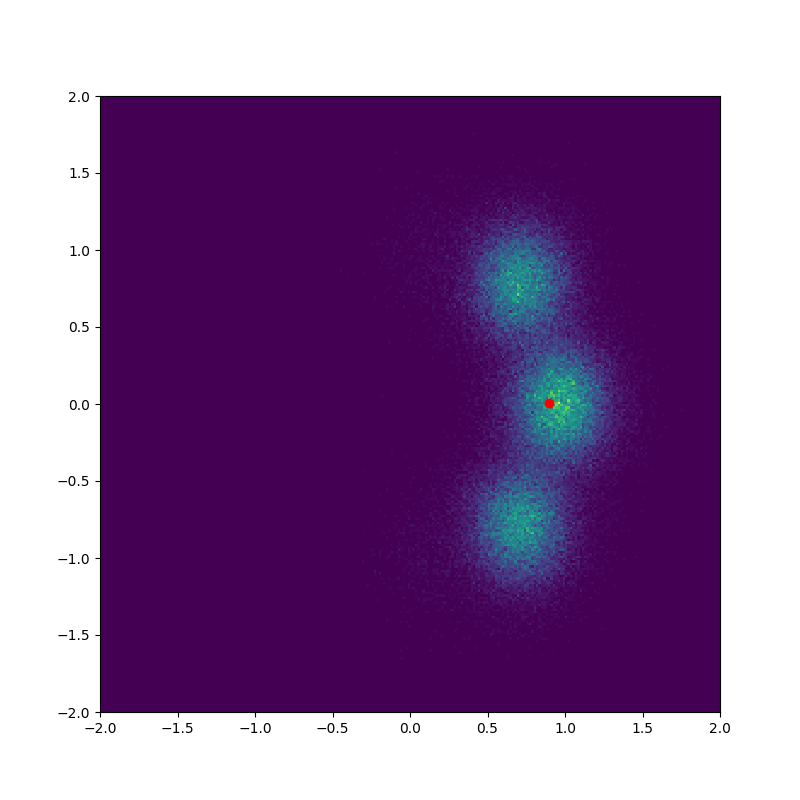

In [2]:
from scipy.stats import multivariate_normal
from sklearn.datasets import make_moons


class DataDistribution:
    def __init__(self, config):
        self.mu = []
        self.sig = []
        self.L_sig = []
        self.generator = np.random.RandomState(0)
        # get mus from config
        for i in range(len(config['gaussians'])):
            self.mu.append(np.array(config['gaussians'][i]['mu']))
            self.sig.append(np.array(config['gaussians'][i]['cov']))
            self.L_sig.append(np.linalg.cholesky(self.sig[i]))
        self.mu = np.array(self.mu)
        self.sig = np.array(self.sig)
        self.L_sig = np.array(self.L_sig)

    def __call__(self, n_samples=1):
        # sample which gaussian to sample from use random state
        idx = np.random.choice(len(self.mu), n_samples)
        # sample from the chosen gaussian
        
        return self.mu[idx][...,0] + np.einsum("nij, nj->ni", self.L_sig[idx], np.random.randn(n_samples, 2)) #self.L_sig[idx]@np.random.randn(2, n_samples).T)
    
    def sample(self, n_samples=1):
        return self(n_samples)

config = {
'gaussians': [
    {'mu': [[3],[-6]], 'cov': [[1,0.25],[0.25,1]]},
    {'mu': [[-2],[3]], 'cov': [[2,-1.5],[-1.5,2]]},
    {'mu': [[3],[6]], 'cov': [[0.2,-0.1],[-0.1,2]]}
]}

data_dist = DataDistribution(config)

# config for 8 gaussians in a circle
r  = 1
sigma = 5e-2
n_gaussians = 7
config_circle = {
'gaussians': [
    {'mu': [[r*np.cos(2*np.pi*i/n_gaussians)],[r*np.sin(2*np.pi*i/n_gaussians)]], 'cov': [[sigma,0],[0,sigma]]} for i in range(n_gaussians)
]}

gaussian_circle = DataDistribution(config_circle)

# define forward process and degrade data with forward process and noise
class BasicForwardModel:
    def __init__(self, data_distribution, config):
        self.data_dist = data_distribution
        # identity matrix
        self.A = np.array([[1,0],[0,1]])
        # noise level
        self.mu = np.array(config['mu'])
        self.sig = np.diag(np.array(config['cov']))
        self.L_sig = np.linalg.cholesky(self.sig)
    
    def __call__(self, n_samples=1):
        # forward process
        x = self.data_dist(n_samples)
        # forward operator
        y = x@self.A.T
        # add noise
        
        y += (self.L_sig@np.random.randn(2, n_samples)).T + self.mu[None]
        return y
    
    def get_p_y(self, y):
        p_y = []
        for j in range(self.data_dist.mu.shape[0]):
            mu = self.A@self.data_dist.mu[j] + self.mu[:,None]
            sig = self.A@self.data_dist.sig[j]@self.A.T + self.sig
            p_y.append(multivariate_normal.pdf(y, mean=mu[:,0],cov=sig))
        return p_y
    
    def unnormalized_posterior(self, y):
        self.post_mu = []
        self.post_sig = []
        self.post_cholesky = []
        for i in range(self.data_dist.mu.shape[0]):
            mu_data = self.data_dist.mu[i][None]
            sig_data = self.data_dist.sig[i][None]
            mu_post = mu_data + (sig_data @ np.linalg.inv(sig_data + self.sig)) @ (y[...,None] - self.A[None]@mu_data)
            self.post_mu.append(mu_post[0])
            sig_post = sig_data - self.A[None]@sig_data @ np.linalg.inv(sig_data + self.sig) @ self.A[None]@sig_data
            self.post_sig.append(sig_post[0])
            self.post_cholesky.append(np.linalg.cholesky(sig_post[0]))
        self.post_mu = np.array(self.post_mu)
        self.post_sig = np.array(self.post_sig)
        self.post_cholesky = np.array(self.post_cholesky)
    
    def sample_posterior(self, y, n_samples=1):
        self.unnormalized_posterior(y)
        p_y = self.get_p_y(y)
        # sample idx of gaussian with probability p_y
        idx = np.random.choice(self.post_mu.shape[0], n_samples, p=p_y/np.sum(p_y))
        return self.post_mu[idx][...,0] + np.einsum("nij, nj->ni", self.post_cholesky[idx], np.random.randn(n_samples, 2))

    def set_A(self, A):
        self.A = A


class MoonDataset:
    def __init__(noise=0.05):
        self.noise = noise

    def __call__(self, n_samples=1):
        x = make_moons(n_samples, noise=self.noise)[0]
        x = torch.tensor(x).type(torch.float32)
        return x
    
    def sample(self, n_samples=1):
        return self(n_samples)
    
measurement_model = BasicForwardModel(gaussian_circle, {'mu': [0,0], 'cov': [0.1,0.1]})
# projection on x-axis
measurement_model.set_A(np.array([[1,0],[0,0]]))
# plot posterior samples
# 1. sample measurement
y = measurement_model(1)
y_samples = measurement_model(100000)
n_samples = 100000
post_samples = measurement_model.sample_posterior(y, n_samples)
# plot measurement_model.post_mu
# aspect ratio 1:1
plt.figure(figsize=(8,8))
# plot
plt.hist2d(post_samples[:,0],post_samples[:,1],bins=256, range=[[-2, 2], [-2, 2]])
plt.scatter(y[0,0],y[0,1],c='r')
plt.show()


# Define Network

In [3]:
# define score matching network
from torch import nn
from torch.nn import functional as F
class BasicScoreNet(nn.Module):
    def __init__(self, hidden_size=128):
        super(BasicScoreNet, self).__init__()
        self.fc1 = nn.Linear(3, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, 2)
       
        
    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = F.leaky_relu(self.fc5(x))
        x = self.fc6(x)
        return x

    def sample(self, t, x):
        t = torch.ones(x.shape[0],1, device=x.device).type(torch.float32)*t
        x = torch.cat([x, t],1)
        return self.forward(x)

## DDPM Training

In [4]:
# DDPM / VP score matching
beta_min = 1e-4
beta_max = 0.02
num_steps = 1000
betas = torch.linspace(beta_min,beta_max,num_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
training_iterations = 20000

batch_size = 500
denoiser = BasicScoreNet(hidden_size=256).to(device)
optimizer = torch.optim.AdamW(denoiser.parameters(),1e-4,(.9,.999),weight_decay=1e-2)
data = gaussian_circle
for i in range(training_iterations):
    # sample timestep
    t = torch.randint(0,num_steps,(batch_size,)).to(device)
    alpha_cumprod_t = alpha_cumprod[t]
    # sample datapoint
    x = torch.tensor(data.sample(batch_size)).type(torch.float32).to(device)
    # sample noise
    eps = torch.randn(batch_size,2).to(device)
    # noise sample
    x_t = alpha_cumprod_t[:,None] * x + eps * (1-alpha_cumprod_t[:,None])
    # compute scores
    eps_pred = denoiser(torch.cat([x_t, t[:,None]/1000], 1))
    # compute loss
    loss = torch.mean((eps_pred - eps)**2)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0: print(loss.item())

print('done')
print(f"loss: {loss.item()}")


0.9892091155052185
0.33869537711143494
0.2523966431617737
0.26599955558776855
0.2673329710960388
0.2970890402793884
0.21550017595291138
0.2978062033653259
0.2230023890733719
0.22874674201011658
0.19123034179210663
0.23743870854377747
0.2696908116340637
0.2102094143629074
0.23649397492408752
0.2570406198501587
0.21172772347927094
0.18611350655555725
0.22226880490779877
0.24114789068698883
0.26722022891044617
0.2594568431377411
0.22013120353221893
0.21810801327228546
0.17616263031959534
0.23566734790802002
0.20160382986068726
0.2141992449760437
0.20242123305797577
0.24986886978149414
0.21955028176307678
0.23744376003742218
0.223591610789299
0.233076274394989
0.20976313948631287
0.19511790573596954
0.2149045467376709
0.2036370187997818
0.22295615077018738
0.20269370079040527
0.23716188967227936
0.21788296103477478
0.23236346244812012
0.18655119836330414
0.23872901499271393
0.22122745215892792
0.27086982131004333
0.23897132277488708
0.18788063526153564
0.2790335714817047
0.2536759972572326

## Flow Matching Training

In [5]:
from tqdm import tqdm

# Flow Matching
training_iterations = 10000

batch_size = 500
denoiser_flow = BasicScoreNet(hidden_size=256).to(device)
optimizer = torch.optim.AdamW(denoiser_flow.parameters(),1e-3,(.9,.999),weight_decay=1e-2)
sig_min = 1e-4
data = gaussian_circle
for i in tqdm(range(training_iterations)):
    # sample timestep
    t = torch.rand((batch_size,)).to(device)[:, None]
    # sample datapoint
    x1 = torch.tensor(data.sample(batch_size)).type(torch.float32).to(device)
    # sample noise
    x0 = torch.randn(batch_size, 2).to(device)
    # interpolate between samples
    x_t = (sig_min + (1 - sig_min) * t) * x1 + (1 - t) * x0
    # compute drift v
    v = denoiser_flow(torch.cat([x_t, t], 1))
    # compute loss
    loss = torch.mean((v - (x1 - x0 * (1 - sig_min))) ** 2)
    # backprop
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    if i % 100 == 0:
        tqdm.write(f"Loss: {loss.item()}")

print('done')
print(f"loss: {loss.item()}")


  0%|          | 0/10000 [00:00<?, ?it/s]

  1%|          | 62/10000 [00:00<00:28, 351.00it/s]

Loss: 1.6151859760284424
Loss: 1.1503697633743286


  3%|▎         | 252/10000 [00:00<00:21, 451.18it/s]

Loss: 1.1785718202590942


  3%|▎         | 349/10000 [00:00<00:20, 466.28it/s]

Loss: 1.1493264436721802


  5%|▍         | 490/10000 [00:01<00:21, 446.21it/s]

Loss: 1.1126646995544434


  6%|▌         | 585/10000 [00:01<00:20, 459.45it/s]

Loss: 1.1204214096069336


  7%|▋         | 678/10000 [00:01<00:20, 451.78it/s]

Loss: 1.0700548887252808


  8%|▊         | 775/10000 [00:01<00:20, 460.48it/s]

Loss: 1.1322641372680664


  9%|▊         | 869/10000 [00:01<00:20, 451.39it/s]

Loss: 1.223834753036499


 10%|▉         | 969/10000 [00:02<00:19, 459.53it/s]

Loss: 1.0813530683517456


 11%|█         | 1069/10000 [00:02<00:18, 475.87it/s]

Loss: 1.1254647970199585


 12%|█▏        | 1167/10000 [00:02<00:18, 473.14it/s]

Loss: 1.0649771690368652


 13%|█▎        | 1262/10000 [00:02<00:19, 453.76it/s]

Loss: 1.163906216621399


 14%|█▎        | 1354/10000 [00:03<00:19, 448.86it/s]

Loss: 1.046661615371704


 15%|█▌        | 1508/10000 [00:03<00:17, 491.00it/s]

Loss: 1.167007327079773
Loss: 1.032838225364685


 17%|█▋        | 1656/10000 [00:03<00:17, 472.95it/s]

Loss: 1.1063917875289917
Loss: 1.075760841369629


 19%|█▉        | 1888/10000 [00:04<00:14, 551.93it/s]

Loss: 1.0880471467971802
Loss: 1.0676898956298828


 21%|██        | 2062/10000 [00:04<00:13, 568.45it/s]

Loss: 1.1538463830947876
Loss: 1.1602373123168945


 23%|██▎       | 2287/10000 [00:04<00:14, 546.84it/s]

Loss: 1.221462607383728
Loss: 1.1678566932678223


 25%|██▍       | 2453/10000 [00:05<00:13, 546.34it/s]

Loss: 1.078481674194336


 26%|██▌       | 2563/10000 [00:05<00:14, 499.54it/s]

Loss: 1.0854027271270752
Loss: 1.106403112411499


 28%|██▊       | 2777/10000 [00:05<00:13, 526.42it/s]

Loss: 1.0784657001495361
Loss: 1.1204557418823242


 30%|███       | 3001/10000 [00:06<00:12, 551.41it/s]

Loss: 1.0666300058364868
Loss: 1.1805105209350586


 32%|███▏      | 3165/10000 [00:06<00:14, 482.64it/s]

Loss: 1.0847132205963135


 33%|███▎      | 3268/10000 [00:06<00:13, 491.16it/s]

Loss: 1.1629589796066284
Loss: 1.0892468690872192


 35%|███▍      | 3478/10000 [00:07<00:13, 469.52it/s]

Loss: 1.1474597454071045


 36%|███▌      | 3574/10000 [00:07<00:13, 472.70it/s]

Loss: 1.0884828567504883


 37%|███▋      | 3670/10000 [00:07<00:13, 465.85it/s]

Loss: 1.0889760255813599


 38%|███▊      | 3765/10000 [00:07<00:13, 459.56it/s]

Loss: 1.0723096132278442


 39%|███▊      | 3858/10000 [00:07<00:14, 438.33it/s]

Loss: 1.0956933498382568


 40%|███▉      | 3956/10000 [00:08<00:13, 459.91it/s]

Loss: 1.1148381233215332


 41%|████      | 4058/10000 [00:08<00:12, 482.38it/s]

Loss: 1.132656455039978
Loss: 1.1378575563430786


 43%|████▎     | 4284/10000 [00:08<00:10, 528.41it/s]

Loss: 0.9882386326789856
Loss: 1.0310120582580566


 45%|████▍     | 4493/10000 [00:09<00:11, 496.42it/s]

Loss: 1.2069547176361084


 45%|████▌     | 4544/10000 [00:09<00:11, 484.25it/s]

Loss: 1.0070332288742065


 47%|████▋     | 4688/10000 [00:09<00:11, 461.24it/s]

Loss: 1.0770398378372192


 48%|████▊     | 4780/10000 [00:09<00:11, 442.29it/s]

Loss: 1.1315652132034302


 49%|████▉     | 4885/10000 [00:10<00:10, 483.64it/s]

Loss: 1.122269630432129
Loss: 1.1894922256469727


 51%|█████     | 5085/10000 [00:10<00:09, 493.84it/s]

Loss: 1.1834022998809814
Loss: 1.1226571798324585


 53%|█████▎    | 5295/10000 [00:10<00:09, 508.14it/s]

Loss: 1.0847489833831787
Loss: 1.1018720865249634


 55%|█████▍    | 5465/10000 [00:11<00:08, 544.91it/s]

Loss: 1.1435006856918335
Loss: 1.045912504196167


 57%|█████▋    | 5693/10000 [00:11<00:07, 565.05it/s]

Loss: 1.1663599014282227
Loss: 1.0503575801849365


 59%|█████▊    | 5866/10000 [00:12<00:07, 565.96it/s]

Loss: 1.0390561819076538
Loss: 1.0669620037078857


 61%|██████    | 6099/10000 [00:12<00:06, 574.50it/s]

Loss: 1.1852302551269531
Loss: 1.0779706239700317


 63%|██████▎   | 6272/10000 [00:12<00:06, 570.26it/s]

Loss: 1.053198218345642
Loss: 1.0723947286605835


 65%|██████▌   | 6504/10000 [00:13<00:06, 557.28it/s]

Loss: 1.073537826538086
Loss: 1.0508989095687866


 67%|██████▋   | 6676/10000 [00:13<00:05, 559.64it/s]

Loss: 1.0150202512741089
Loss: 1.0393307209014893


 69%|██████▉   | 6905/10000 [00:13<00:05, 564.55it/s]

Loss: 1.180597186088562
Loss: 1.09115731716156


 71%|███████   | 7080/10000 [00:14<00:05, 574.56it/s]

Loss: 1.1700712442398071
Loss: 1.0554448366165161


 73%|███████▎  | 7310/10000 [00:14<00:04, 559.32it/s]

Loss: 1.0966578722000122
Loss: 1.0991932153701782


 75%|███████▍  | 7482/10000 [00:14<00:04, 524.42it/s]

Loss: 1.1279337406158447


 76%|███████▌  | 7595/10000 [00:15<00:04, 542.56it/s]

Loss: 1.0733493566513062
Loss: 1.064091682434082


 78%|███████▊  | 7768/10000 [00:15<00:03, 564.24it/s]

Loss: 1.2170499563217163
Loss: 1.1184178590774536


 80%|███████▉  | 7997/10000 [00:15<00:03, 562.91it/s]

Loss: 1.063043475151062
Loss: 0.9542209506034851


 82%|████████▏ | 8171/10000 [00:16<00:03, 570.09it/s]

Loss: 1.0370839834213257
Loss: 1.0574008226394653


 84%|████████▍ | 8403/10000 [00:16<00:02, 572.03it/s]

Loss: 1.029983639717102
Loss: 1.141943097114563


 86%|████████▌ | 8579/10000 [00:16<00:02, 577.14it/s]

Loss: 1.10335111618042
Loss: 1.0195562839508057


 88%|████████▊ | 8813/10000 [00:17<00:02, 561.27it/s]

Loss: 1.1198108196258545
Loss: 1.097013235092163


 90%|████████▉ | 8988/10000 [00:17<00:01, 566.23it/s]

Loss: 1.0685962438583374
Loss: 1.04087495803833


 92%|█████████▏| 9159/10000 [00:17<00:01, 562.40it/s]

Loss: 1.0674432516098022
Loss: 1.1261454820632935


 94%|█████████▍| 9391/10000 [00:18<00:01, 575.99it/s]

Loss: 1.0779459476470947
Loss: 1.1112414598464966


 96%|█████████▌| 9567/10000 [00:18<00:00, 578.22it/s]

Loss: 1.048221230506897
Loss: 1.078636646270752


 98%|█████████▊| 9799/10000 [00:18<00:00, 528.79it/s]

Loss: 1.0584437847137451


 99%|█████████▉| 9911/10000 [00:19<00:00, 542.91it/s]

Loss: 1.0633164644241333
Loss: 1.0009516477584839


100%|██████████| 10000/10000 [00:19<00:00, 517.01it/s]

done
loss: 1.0621739625930786


## DDIM Test Time Guidance


start point tensor([[-1.3872,  0.3738]])


Text(0.5, 1.0, 'Density and Trajectory DDIM eta=0.0')

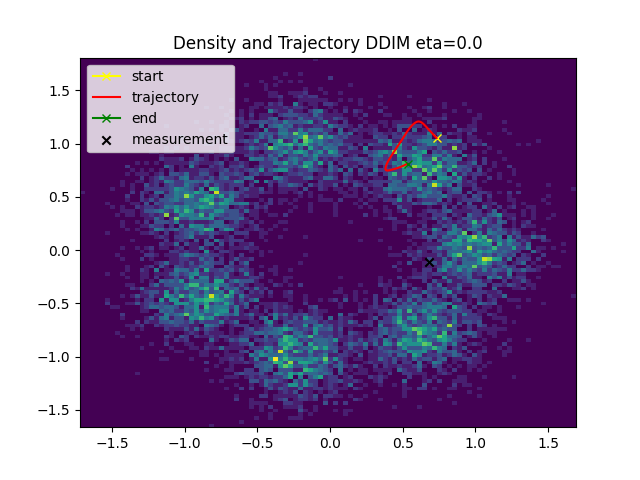

In [324]:

x_t = torch.randn(1,2).to(device)
print("start point", x_t)
# generate measurement y
measurement_model = BasicForwardModel(data, {'mu': [0,0], 'cov': [0.1,0.1]})
measurement_model.set_A(np.array([[1,0],[0,0]]))
y = torch.Tensor(measurement_model(1)).to(device)



def guided_ddim_sampler(model, y, ddim_config, x_t, likelihood_weight = 0.005, save_traj=False):
    if x_t is None:
        x_t = torch.randn(1,2).to(device)
    n_ddim_steps = ddim_config['n_ddim_steps']
    n_steps = ddim_config['n_steps']
    eta = ddim_config['eta']
    skip = int(n_steps/n_ddim_steps)
    timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
    betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
    alpha = 1 - betas
    alpha_cumprod = torch.cumprod(alpha, 0)
    if save_traj:
        traj = [x_t.detach().cpu().numpy()]
    for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
        with torch.no_grad():
            a_t = alpha_cumprod[t]
            a_t_next = alpha_cumprod[t_next]
            eps_pred = model(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t/1000], 1))
            # ddim step
            x0_t = (x_t - eps_pred * (1-a_t)**0.5) / a_t**0.5
            c1 = eta * ((1-a_t/a_t_next)* (1-a_t_next)/(1-a_t))**0.5
            c2 = ((1-a_t_next) - c1 **2)**0.5
            x_t = a_t_next**0.5 *x0_t + c1 * torch.randn_like(x_t) + c2 * eps_pred
            with torch.enable_grad():
                x_t.requires_grad_()
                y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_t.T).T
                loss = torch.sum((y_generated - y)**2)
                loss.backward()
                gradients = x_t.grad
            # data term
            x_t = x_t - likelihood_weight * gradients
            if save_traj:
                traj.append(x_t.detach().cpu().numpy())
    return traj if save_traj else [x_t.detach().cpu().numpy()]

ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.0}
x_t = torch.randn(1,2).to(device)
traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t, save_traj=True)
# draw trajectory on density plot
plt.figure()
plt.title('Density and Trajectory')
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot meaasurement y
plt.scatter(y[0,0].detach().cpu().numpy(),y[0,1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','end', 'measurement'])
# name
plt.title(f'Density and Trajectory DDIM eta={ddim_config["eta"]}')



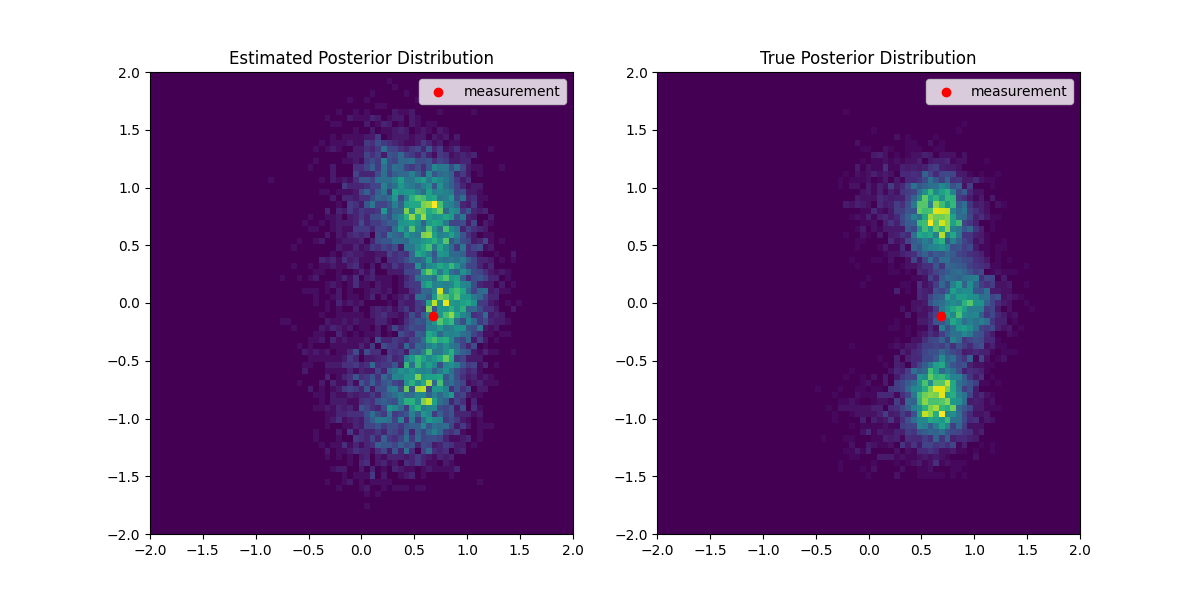

In [330]:
# compare posterior
n_samples = 10000
bins = 75
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 1}
x_t = torch.randn(n_samples,2).to(device)
traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t, likelihood_weight=0.003)
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
hist = axs[0].hist2d(traj[-1][:,0], traj[-1][:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])

# Plot true posterior distribution
axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])

plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]



In [331]:
# benchmark dataset
y_measurements = torch.Tensor(measurement_model(100)).to(device)

In [333]:
def compute_WD(ground_truth_samples, estimated_samples):
    bins = 75
    H1, x_edges, y_edges = np.histogram2d(ground_truth_samples[:, 0], ground_truth_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    H2, _, _ = np.histogram2d(estimated_samples[:, 0], estimated_samples[:, 1], bins=bins, range=[[-1.5, 1.5], [-1.5, 1.5]])
    # normalize
    H1 = H1 / np.sum(H1)
    H2 = H2 / np.sum(H2)
    # Create cost matrix for the binned data
    x_centers = 0.5 * (x_edges[:-1] + x_edges[1:])  # Bin centers for x
    y_centers = 0.5 * (y_edges[:-1] + y_edges[1:])  # Bin centers for y

    # Create a grid of centers
    X, Y = np.meshgrid(x_centers, y_centers)

    # Flatten the grid to match flattened histograms
    grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)

    # Compute pairwise squared distances between all grid points
    cost_matrix = np.linalg.norm(grid_points[:, None, :] - grid_points[None, :, :], axis=2)


    wasserstein_distance_histogram = emd2(H1.flatten(), H2.flatten(), cost_matrix)
    return wasserstein_distance_histogram

In [332]:
wd_distances = []
for y in y_measurements:
    # compare posterior
    n_samples = 10000
    bins = 75
    ddim_config = {'n_ddim_steps': 100, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.0}
    
    x_t = torch.randn(n_samples,2).to(device)
    traj = guided_ddim_sampler(denoiser, y,ddim_config , x_t)
    # sample from true posterior
    ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
    # histogram
    wasserstein_distance_histogram = compute_WD(ground_truth_samples, traj[-1])
    print("Wasserstein Distance on Binned Data:", wasserstein_distance_histogram)
    wd_distances.append(wasserstein_distance_histogram)
wd_distances = np.array(wd_distances)
print("Mean Wasserstein Distance:", np.mean(wd_distances))


Wasserstein Distance on Binned Data: 1.051116882537157
Wasserstein Distance on Binned Data: 0.5931027938826917
Wasserstein Distance on Binned Data: 0.5452721097779366
Wasserstein Distance on Binned Data: 1.2430660662058874
Wasserstein Distance on Binned Data: 1.6262319264818705
Wasserstein Distance on Binned Data: 0.2562242592418519
Wasserstein Distance on Binned Data: 1.4294309729547134
Wasserstein Distance on Binned Data: 0.29963896345041974
Wasserstein Distance on Binned Data: 1.4393354909965088
Wasserstein Distance on Binned Data: 1.571516367467851
Wasserstein Distance on Binned Data: 0.7520537204974617
Wasserstein Distance on Binned Data: 1.4346793702155054
Wasserstein Distance on Binned Data: 1.3255906958853336
Wasserstein Distance on Binned Data: 0.5904086371988145
Wasserstein Distance on Binned Data: 0.33764202101199087
Wasserstein Distance on Binned Data: 0.6522508072231895
Wasserstein Distance on Binned Data: 1.0406821941123903
Wasserstein Distance on Binned Data: 0.173201536

In [295]:
# flow matching posterior
def guided_flow_sampler(model, y, config, x_t, save_traj=False):
    if x_t is None:
        x_t = torch.randn(1,2).to(device)
    n_steps = config['n_steps']
    likelihood_weight = config['likelihood_weight']
    timesteps = np.linspace(0, 1, n_steps)
    if save_traj:
        traj = [x_t.detach().cpu().numpy()]
    with torch.no_grad():
        for i, (t_prev, t_curr) in enumerate(zip(timesteps[:-1], timesteps[1:])):
            v_pred = model(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t_curr], 1))
            dt = t_curr - t_prev
            with torch.enable_grad():
                x_t.requires_grad_()
                y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_t.T).T
                loss = torch.sum((y_generated - y)**2)
                loss.backward()
                gradients = x_t.grad
            x_t = x_t + dt * v_pred - gradients * likelihood_weight
            if save_traj:
                traj.append(x_t.detach().cpu().numpy())
    return traj if save_traj else [x_t.detach().cpu().numpy()]



In [296]:
y = y_measurements[0]
y = torch.Tensor(measurement_model(1)[0]).to(device)

Text(0.5, 1.0, 'Density and Trajectory Flow Matching')

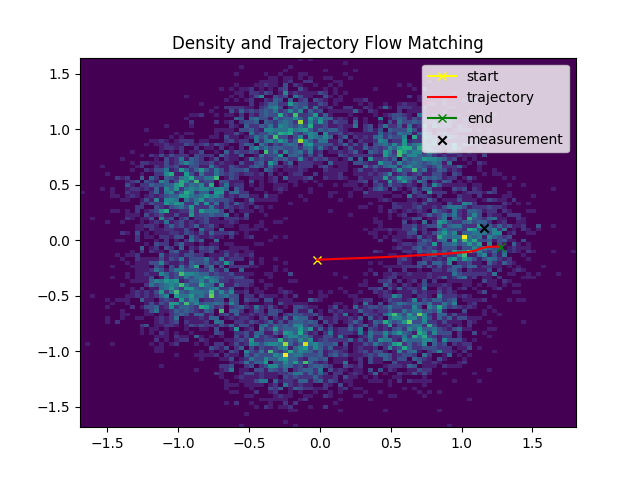

In [299]:
# plot trajecotry of one point
config = {'n_steps': 50, 'likelihood_weight': 0.05}
n_samples = 10000
bins = 75
x_t = torch.randn(1,2).to(device)

traj = guided_flow_sampler(denoiser_flow, y, config, x_t, save_traj=True)
plt.figure()
plt.title('Density and Trajectory')
data_samples = data.sample(n_samples)
plt.hist2d(data_samples[:,0],data_samples[:,1],bins=100)
# plot trajectory
traj = np.array(traj)
plt.plot(traj[0,0,0],traj[0,0,1], color='yellow', marker='x')
plt.plot(traj[:,0,0],traj[:,0,1], color='red')
plt.plot(traj[-1,0,0],traj[-1,0,1], color='green', marker='x')
# plot meaasurement y
plt.scatter(y[0].detach().cpu().numpy(),y[1].detach().cpu().numpy(), color='black', marker='x')
# add legend
plt.legend(['start','trajectory','end', 'measurement'])
# name
plt.title(f'Density and Trajectory Flow Matching')


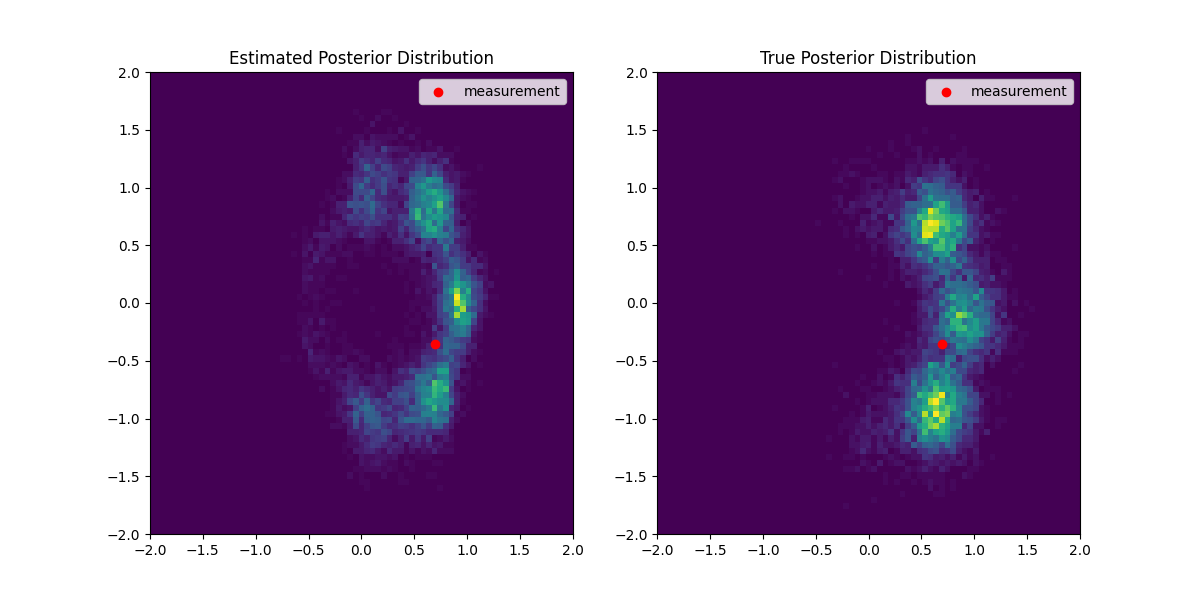

In [322]:
# compare posterior
config = {'n_steps': 50, 'likelihood_weight': 0.01}
n_samples = 10000
bins = 75
x_t = torch.randn(n_samples,2).to(device)
y = y_measurements[0]
x_0 = guided_flow_sampler(denoiser_flow, y, config, x_t)[-1]
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].set_title('Estimated Posterior Distribution')
hist = axs[0].hist2d(x_0[:,0], x_0[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0].detach().cpu().numpy(), y[1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])
axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0].detach().cpu().numpy(), y[1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])
plt.show()


In [334]:
# measure Wasserstein distance flow matching
wd_distances = []
for y in y_measurements:
    # compare posterior
    n_samples = 10000
    x_t = torch.randn(n_samples,2).to(device)
    x_0 = guided_flow_sampler(denoiser_flow, y, config, x_t)[-1]
    # sample from true posterior
    ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
    # histogram
    wasserstein_distance_histogram = compute_WD(ground_truth_samples, traj[-1])
    print("Wasserstein Distance on Binned Data:", wasserstein_distance_histogram)
    wd_distances.append(wasserstein_distance_histogram)
wd_distances = np.array(wd_distances)
print("Mean Wasserstein Distance:", np.mean(wd_distances))

Wasserstein Distance on Binned Data: 1.34214372013477
Wasserstein Distance on Binned Data: 0.33988412519129524
Wasserstein Distance on Binned Data: 0.3089911387082126
Wasserstein Distance on Binned Data: 1.515121274388789
Wasserstein Distance on Binned Data: 1.8747203780761668
Wasserstein Distance on Binned Data: 0.3705920253802466
Wasserstein Distance on Binned Data: 1.6815056846141168
Wasserstein Distance on Binned Data: 0.6006978816005916
Wasserstein Distance on Binned Data: 1.7056190102865647
Wasserstein Distance on Binned Data: 1.8198915191505618
Wasserstein Distance on Binned Data: 1.0518945517165748
Wasserstein Distance on Binned Data: 1.694670812027659
Wasserstein Distance on Binned Data: 1.5926531735567033
Wasserstein Distance on Binned Data: 0.29974085018635077
Wasserstein Distance on Binned Data: 0.24471937374483096
Wasserstein Distance on Binned Data: 0.9430135494690511
Wasserstein Distance on Binned Data: 1.3296613879200896
Wasserstein Distance on Binned Data: 0.2189015355

In [377]:
# variational inference DDIM
n_samples = 10000
bins = 75
ddim_config = {'n_ddim_steps': 1000, 'n_steps': 1000, 'beta_min': 1e-4, 'beta_max': 0.02, 'eta': 0.5, "likelihood_weight": 0.5, "regularizer_weight": 0.5}
x_t = torch.randn(n_samples,2).to(device)
y = y_measurements[:1]
x_mu = x_t
x_sigma = torch.ones_like(x_t)
save_traj = False
n_ddim_steps = ddim_config['n_ddim_steps']
n_steps = ddim_config['n_steps']
eta = ddim_config['eta']
regularizer_weight = ddim_config['regularizer_weight']
likelihood_weight = ddim_config['likelihood_weight']
skip = int(n_steps/n_ddim_steps)
timesteps = np.arange(skip,n_steps+skip,skip).astype(int)[::-1] - 1
betas = torch.linspace(ddim_config['beta_min'],ddim_config['beta_max'],n_steps).to(device)
alpha = 1 - betas
alpha_cumprod = torch.cumprod(alpha, 0)
if save_traj:
    traj = [x_t.detach().cpu().numpy()]
for t, t_next in zip(timesteps, np.concatenate([timesteps[1:], [0]])):
    with torch.no_grad():
        eta_t = (1 + x_sigma**2* (alpha_cumprod[t]/(1-alpha_cumprod[t]))**2)**0.5
        a_t = alpha_cumprod[t]
        a_t_next = alpha_cumprod[t_next]
        eps = torch.randn(x_mu.shape[0],2).to(device)
        x_t = alpha_cumprod[t,None] * x_mu + eps * (1-alpha_cumprod[t,None])
        eps_pred = denoiser(torch.cat([x_t, torch.ones(x_t.shape[0],1).to(device)*t/1000], 1))
        dx_reg = (eps_pred - eps) * (1-alpha_cumprod[t])/alpha_cumprod[t]
        with torch.enable_grad():
            x_mu.requires_grad_()
            y_generated = (torch.Tensor(measurement_model.A).to(device) @ x_mu.T).T
            loss = torch.sum((y_generated - y)**2, dim=1)
            loss.backward(torch.ones_like(loss))
            gradients = x_mu.grad
        # data term
        x_mu = x_mu - likelihood_weight *  gradients - regularizer_weight * dx_reg
# sample from true posterior
ground_truth_samples = measurement_model.sample_posterior(y.detach().cpu().numpy(), n_samples)
# plot posterior distribution
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


# Plot estimated posterior distribution
axs[0].set_title('Estimated Posterior Distribution')
hist = axs[0].hist2d(x_mu[:,0], x_mu[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[0].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[0].legend(['measurement'])

# Plot true posterior distribution
axs[1].set_title('True Posterior Distribution')
hist = axs[1].hist2d(ground_truth_samples[:,0], ground_truth_samples[:,1], bins=bins, range=[[-2, 2], [-2, 2]])
axs[1].scatter(y[0,0].detach().cpu().numpy(), y[0,1].detach().cpu().numpy(), c='r')
axs[1].legend(['measurement'])


plt.show()
# compute Wasserstein distance of posterior samples and true posterior
estimated_samples = traj[-1]
